# Installing Modules

In [ ]:
%%capture
!pip install spacy==3
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

## Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

In [2]:
# Import Libraries
import random
from typing import Iterable, List, Tuple
import pandas as pd
import sys, os, pickle
import numpy as np
import math, time
import matplotlib.pyplot  as plt
import matplotlib.ticker as ticker
import spacy

# PyTorch related
import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

In [5]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

token_transform[SRC_LANGUAGE]  = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # Training data Iterator 
  train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  # Create torchtext's Vocab object 
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)
  
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 961kB/s]


In [7]:
print(f"Length of SRC Vocabulary: {len(vocab_transform['de'])}")
print(f"Length of TRG Vocabulary: {len(vocab_transform['en'])}")

Length of SRC Vocabulary: 19215
Length of TRG Vocabulary: 10838


In [8]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

In [9]:
BATCH_SIZE = 32
train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_loader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 166kB/s]
mmt16_task1_test.tar.gz: 100%|██████████| 43.9k/43.9k [00:00<00:00, 158kB/s]


## Building the Model


In [10]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### Encoder Layer

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Mutli Head Attention Layer

In [12]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer


In [13]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder


In [14]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Decoder Layer

In [100]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

In [101]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2).to(device)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask.to(device)
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model

In [102]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TGT_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [103]:
model = Seq2Seq(enc, dec, PAD_IDX, PAD_IDX, device).to(device)

In [104]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,483,798 trainable parameters


In [105]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [106]:
model.apply(initialize_weights);

In [107]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [108]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [54]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for batch in iterator:
        
        src, trg = batch
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [58]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, trg = batch
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [59]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [60]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'end2_assign_13.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 35s
	Train Loss: 2.605 | Train PPL:  13.537
	 Val. Loss: 2.405 |  Val. PPL:  11.082
Epoch: 02 | Time: 0m 35s
	Train Loss: 2.029 | Train PPL:   7.608
	 Val. Loss: 2.175 |  Val. PPL:   8.806
Epoch: 03 | Time: 0m 35s
	Train Loss: 1.669 | Train PPL:   5.307
	 Val. Loss: 2.085 |  Val. PPL:   8.044
Epoch: 04 | Time: 0m 35s
	Train Loss: 1.406 | Train PPL:   4.079
	 Val. Loss: 2.064 |  Val. PPL:   7.875
Epoch: 05 | Time: 0m 35s
	Train Loss: 1.204 | Train PPL:   3.334
	 Val. Loss: 2.097 |  Val. PPL:   8.145
Epoch: 06 | Time: 0m 36s
	Train Loss: 1.045 | Train PPL:   2.843
	 Val. Loss: 2.154 |  Val. PPL:   8.618
Epoch: 07 | Time: 0m 37s
	Train Loss: 0.917 | Train PPL:   2.501
	 Val. Loss: 2.199 |  Val. PPL:   9.018
Epoch: 08 | Time: 0m 36s
	Train Loss: 0.818 | Train PPL:   2.266
	 Val. Loss: 2.234 |  Val. PPL:   9.333
Epoch: 09 | Time: 0m 36s
	Train Loss: 0.738 | Train PPL:   2.091
	 Val. Loss: 2.288 |  Val. PPL:   9.859
Epoch: 10 | Time: 0m 35s
	Train Loss: 0.673 | Train PPL

In [109]:
model.load_state_dict(torch.load('end2_assign_13.pt'))

test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.072 | Test PPL:   7.938 |


## Inference

In [110]:
def translate_sentence(src_sent_tok, model, device, max_len = 50):

    model.eval()

    src_tensor = torch.LongTensor(src_sent_tok).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
       
    trg_indexes = [BOS_IDX]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == EOS_IDX:
            break
    
    trg_tokens = [vocab_transform['en'].lookup_token(i) for i in trg_indexes]
    
    return trg_tokens[1:], attention



In [136]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(18,18))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

#### Example from Train Dataset

In [163]:
example_idx = 2


src_sent_i = next(iter(train_loader))[0][example_idx,:]
trg_sent_i = next(iter(train_loader))[1][example_idx,:]
stop_ind_src = (src_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
stop_ind_trg = (trg_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
src_sent_i = src_sent_i[:stop_ind_src+1]
trg_sent_i = trg_sent_i[:stop_ind_trg+1]
src_sent_tok = [vocab_transform['de'].lookup_token(word_i) for word_i in src_sent_i[1:stop_ind_src]]
trg_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in trg_sent_i[1:stop_ind_trg]]

print(f'src = {src_sent_tok}')
print(f'trg = {trg_sent_tok}')

src = ['Ein', 'kleines', 'Mädchen', 'klettert', 'in', 'ein', 'Spielhaus', 'aus', 'Holz', '.']
trg = ['A', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']


In [164]:
translation, attention = translate_sentence(src_sent_i, model, device, max_len = 50)
print(f'predicted trg = {translation}')

predicted trg = ['A', 'little', 'girl', 'climbs', 'a', 'wooden', 'hole', 'in', 'a', 'wood', '.', '<eos>']


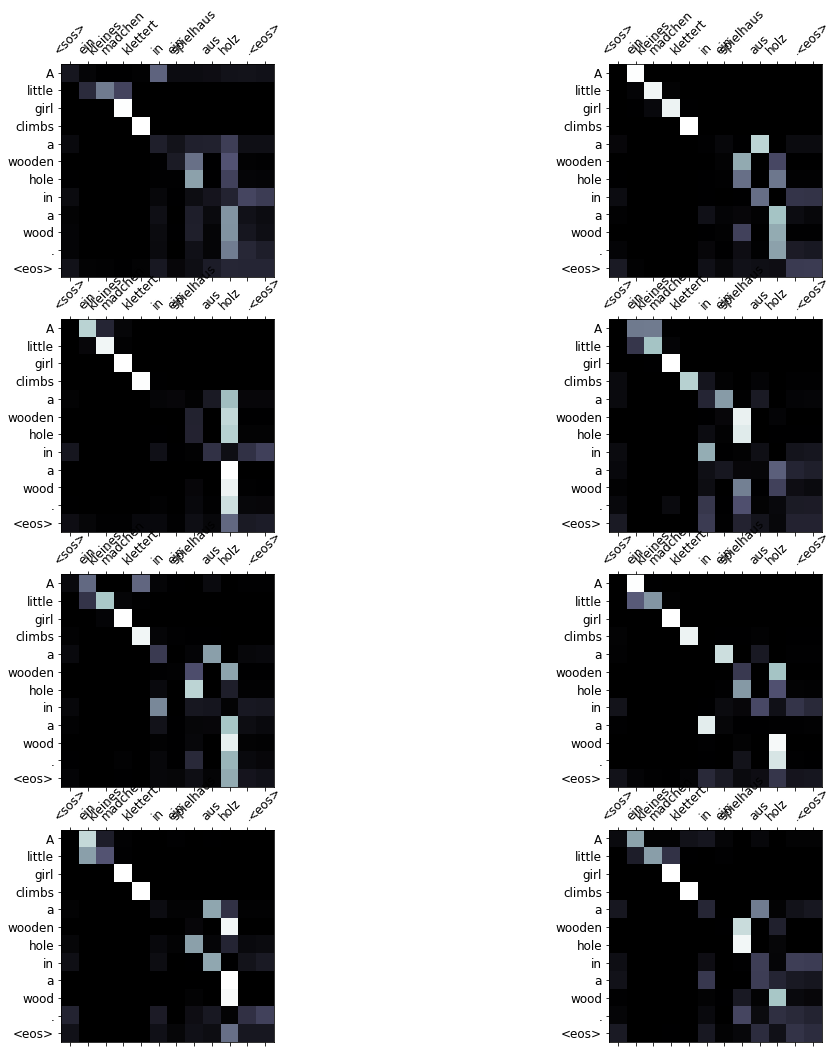

In [165]:
display_attention(src_sent_tok, translation, attention)

#### Example from Validation Dataset

In [174]:
example_idx = 26

src_sent_i = next(iter(val_loader))[0][example_idx,:]
trg_sent_i = next(iter(val_loader))[1][example_idx,:]
stop_ind_src = (src_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
stop_ind_trg = (trg_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
src_sent_i = src_sent_i[:stop_ind_src+1]
trg_sent_i = trg_sent_i[:stop_ind_trg+1]
src_sent_tok = [vocab_transform['de'].lookup_token(word_i) for word_i in src_sent_i[1:stop_ind_src]]
trg_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in trg_sent_i[1:stop_ind_trg]]

print(f'src = {src_sent_tok}')
print(f'trg = {trg_sent_tok}')

src = ['Ein', 'süßes', 'Baby', 'lächelt', 'einem', 'anderen', 'Kind', 'zu', '.']
trg = ['A', 'cute', 'baby', 'is', 'smiling', 'at', 'another', 'child', '.']


In [175]:
translation, attention = translate_sentence(src_sent_i, model, device, max_len = 50)

print(f'predicted trg = {translation}')

predicted trg = ['A', 'happy', 'baby', 'smiles', 'at', 'another', 'child', '.', '<eos>']


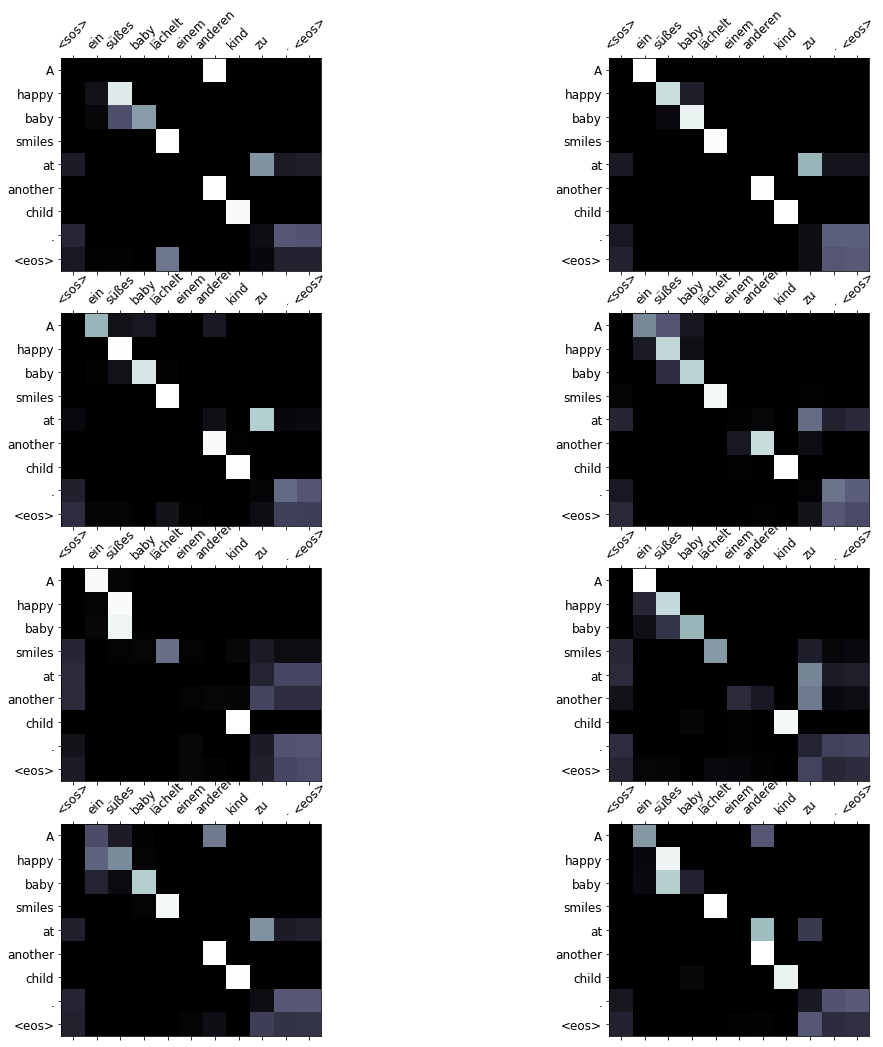

In [176]:
display_attention(src_sent_tok, translation, attention)

#### Example from Test Dataset

In [183]:
example_idx = 8


src_sent_i = next(iter(test_loader))[0][example_idx,:]
trg_sent_i = next(iter(test_loader))[1][example_idx,:]
stop_ind_src = (src_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
stop_ind_trg = (trg_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
src_sent_i = src_sent_i[:stop_ind_src+1]
trg_sent_i = trg_sent_i[:stop_ind_trg+1]
src_sent_tok = [vocab_transform['de'].lookup_token(word_i) for word_i in src_sent_i[1:stop_ind_src]]
trg_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in trg_sent_i[1:stop_ind_trg]]

print(f'src = {src_sent_tok}')
print(f'trg = {trg_sent_tok}')

src = ['Ein', 'Typ', 'arbeitet', 'an', 'einem', 'Gebäude', '.']
trg = ['A', 'guy', 'works', 'on', 'a', 'building', '.']


In [184]:
translation, attention = translate_sentence(src_sent_i, model, device, max_len = 50)
print(f'predicted trg = {translation}')

predicted trg = ['A', 'guy', 'working', 'on', 'a', 'building', '.', '<eos>']


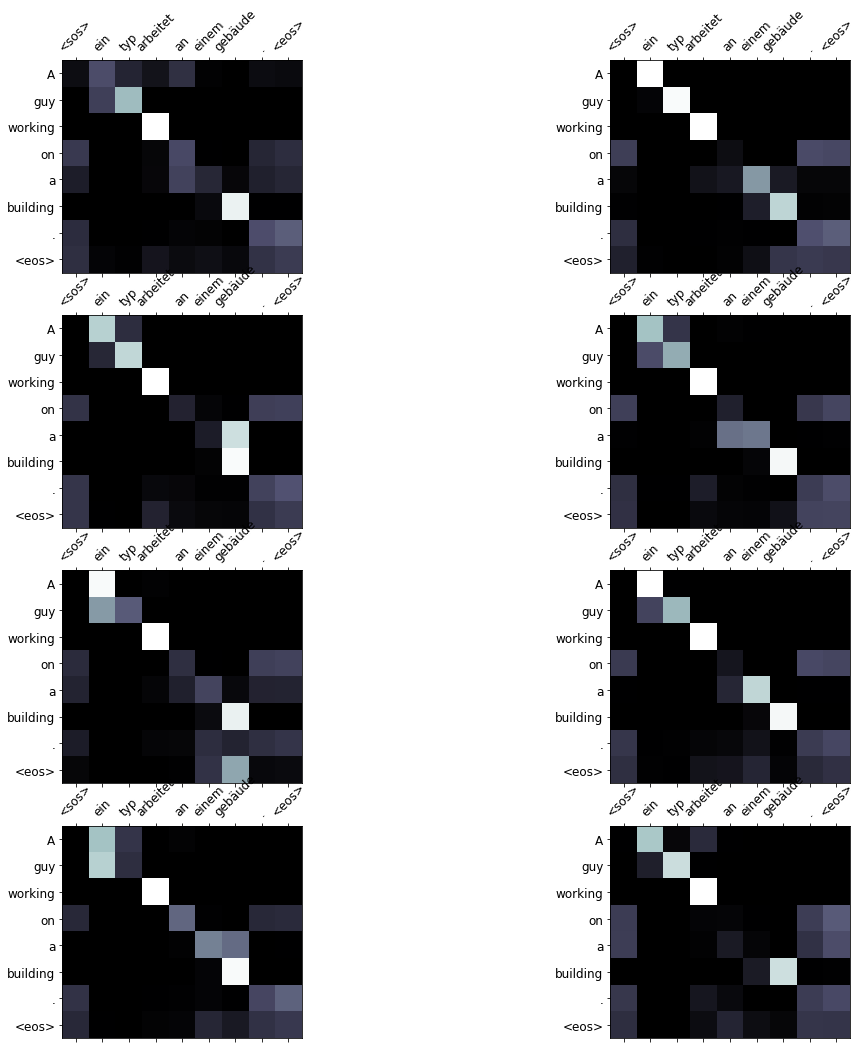

In [185]:
display_attention(src_sent_tok, translation, attention)

## BLEU

In [213]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        for i in range(datum[0].shape[0]):

            src_sent_i = datum[0][i,:]
            trg_sent_i = datum[1][i,:]

            stop_ind_trg = (trg_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
            trg_sent_i = trg_sent_i[:stop_ind_trg+1]
            trg_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in trg_sent_i[1:stop_ind_trg]]

            pred_trg, _ = translate_sentence(src_sent_i, model, device, max_len = 50)

            
            #cut off <eos> token
            pred_trg = pred_trg[:-1]
            
            pred_trgs.append(pred_trg)
            trgs.append([trg_sent_tok])
        
    return bleu_score(pred_trgs, trgs)

In [214]:
bleu_score = calculate_bleu(test_loader, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 31.60


# Inference on Multiple Sample

In [218]:
for i in np.random.randint(0,32, 10):
  src_sent_i = next(iter(train_loader))[0][i,:]
  trg_sent_i = next(iter(train_loader))[1][i,:]
  stop_ind_src = (src_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
  stop_ind_trg = (trg_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
  src_sent_i = src_sent_i[:stop_ind_src+1]
  trg_sent_i = trg_sent_i[:stop_ind_trg+1]
  src_sent_tok = [vocab_transform['de'].lookup_token(word_i) for word_i in src_sent_i[:stop_ind_src]]
  trg_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in trg_sent_i[:stop_ind_trg]]
  src_sent = " ".join(src_sent_tok[1:]) # skip the initial <bos> token
  trg_sent = " ".join(trg_sent_tok[1:]) # skip the initial <bos> token
  src_sent_tensor = src_sent_i.clone().detach().unsqueeze(0).to(device)   
  trg_sent_tensor = trg_sent_i.clone().detach().unsqueeze(0).to(device)
  translation, _ = translate_sentence(src_sent_i, model, device, max_len = 50)
  pred_sent = " ".join(translation[:-1])
  start = "\033[1m"
  end = "\033[0;0m"
  print(f'{start}Source Sentence: {end}{src_sent}')
  print(f'{start}Target Sentence: {end}{trg_sent}')
  print(f'{start}Translated Sentence: {end}{pred_sent}')
  print()

Source Sentence: Eine Frau mit schwarzem Oberteil und Brille streut Puderzucker auf einem Gugelhupf .
Target Sentence: A lady in a black top with glasses is sprinkling powdered sugar on a bundt cake .
Translated Sentence: A woman with a black shirt and glasses is shaping powdered onions in a highchair .

Source Sentence: Fünf Personen sitzen mit Instrumenten im Kreis .
Target Sentence: Five people are sitting in a circle with instruments .
Translated Sentence: Five people sitting in different instruments in a circle .

Source Sentence: Ein kleines Mädchen sitzt vor einem großen gemalten Regenbogen .
Target Sentence: A little girl is sitting in front of a large painted rainbow .
Translated Sentence: A little girl sits in front of a large rainbow .

Source Sentence: Das kleine Kind klettert an roten Seilen auf einem Spielplatz .
Target Sentence: The small child climbs on a red ropes on a playground .
Translated Sentence: The small child climbs on a red rope rope rope .

Source Sentence: 